In [92]:
using Pkg
Pkg.activate("/home/fedflorio/master_thesis/")

  Activating project at `~/master_thesis`


In [93]:
using Revise
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Statistics, Random, LinearAlgebra, PyPlot
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using TensorTrains: summary_compact
using SparseArrays
include("/home/fedflorio/master_thesis/Utilities/roc.jl");

In [94]:
nsnaps = 100
separation = 256
T = nsnaps * separation
N = 10
seed = 4

c = 2
gg = erdos_renyi(N, c/N; seed)
g = IndexedGraph(gg)

λ_unif = 0.02
ρ_unif = 0.02
λ = zeros(N,N)
for i in CartesianIndices(λ)
    if !iszero(g.A[i])
        # λ[i] = rand()
        λ[i] = λ_unif
    end
end
λ = sparse(λ)
# ρ = rand(N)
ρ = fill(ρ_unif,N)
# γ = [i==4 ? 1.0 : 0.0 for i in 1:N]
γ = 0.2
α = fill(1e-4,N)

# T = 7
# N = 2
# seed = 6

# A = [0 1; 1 0]
# g = IndexedGraph(A)

# λ_unif = 0.7
# ρ_unif = 0.6
# λ = sparse(λ_unif .* A)
# # λ = sparse([0 1e-12; λ_unif 0])
# ρ = fill(ρ_unif, N)
# γ = 0.5
;

In [95]:
sis = SIS_heterogeneous(λ, ρ, T; γ, α);
bp_obs = mpbp(sis);

In [96]:
g.A

10×10 SparseMatrixCSC{Int64, Int64} with 30 stored entries:
  ⋅  ⋅   1  2  4   5   ⋅   ⋅   ⋅  14
  ⋅  ⋅   ⋅  ⋅  ⋅   ⋅   ⋅   ⋅   9   ⋅
  1  ⋅   ⋅  3  ⋅   ⋅   6   ⋅  10   ⋅
  2  ⋅   3  ⋅  ⋅   ⋅   7   ⋅   ⋅   ⋅
  4  ⋅   ⋅  ⋅  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  5  ⋅   ⋅  ⋅  ⋅   ⋅   8   ⋅  11   ⋅
  ⋅  ⋅   6  7  ⋅   8   ⋅   ⋅  12   ⋅
  ⋅  ⋅   ⋅  ⋅  ⋅   ⋅   ⋅   ⋅  13   ⋅
  ⋅  9  10  ⋅  ⋅  11  12  13   ⋅  15
 14  ⋅   ⋅  ⋅  ⋅   ⋅   ⋅   ⋅  15   ⋅

In [97]:
obs_times = collect(range(0, step=separation, length=nsnaps))
nobs = floor(Int, N * length(obs_times) * 1.0)
obs_fraction = nobs / N
seed = 3
rng = MersenneTwister(seed)
X, observed = draw_node_observations!(bp_obs, nsnaps, times = obs_times .+ 1, softinf=Inf; rng);

In [98]:
X

10×25601 Matrix{Int64}:
 2  2  2  2  2  2  2  2  2  2  2  2  2  …  2  2  2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2  2  2  2     1  1  1  1  1  1  1  1  1  1  2  2
 2  2  2  2  2  2  2  2  2  2  2  2  2     1  2  2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2  2  2  2     2  2  2  2  2  2  2  2  2  1  1  1
 1  1  2  2  2  2  2  2  2  2  2  2  2     2  2  2  2  2  2  2  2  2  2  2  2
 1  1  1  1  1  1  2  2  2  2  2  2  2  …  1  1  1  1  1  1  1  2  2  2  2  2
 1  1  1  1  1  1  1  2  2  2  2  2  2     1  1  1  1  1  1  2  2  2  2  2  2
 1  2  2  2  2  2  2  2  2  2  2  2  2     2  2  2  2  2  2  2  2  2  2  2  2
 2  2  2  2  2  2  2  2  2  2  2  2  2     2  2  2  2  2  2  2  2  2  2  2  2
 1  1  1  1  1  1  1  1  1  1  1  1  1     2  2  2  2  2  2  2  2  2  2  2  2

In [371]:
λinit = 0.1
ρinit = 0.1

A_complete = ones(N,N) - I
g_complete = IndexedGraph(A_complete)
λ_complete = sparse(λinit.*A_complete)
ρ_complete = fill(ρinit, N)

bp_inf = map(1:nsnaps-1) do i
    obs_sub = [sis.ϕ[a][(i-1)*separation+1:i*separation+1] for a in eachindex(sis.ϕ)]
    sis_inf = SIS_heterogeneous(g_complete, λ_complete, ρ_complete, separation; γ, ϕ=obs_sub)
    bp = mpbp(sis_inf)
end
;

In [372]:
svd_trunc = TruncBond(5)
maxiter = 40

nodes = vertices(bp_obs.g)

λder = [zeros(length(nodes)-1) for n in nodes]
ρder = zeros(length(nodes))
params = []

for it in 1:maxiter
    step = 0.01 * 5^(it≤(maxiter/4))
    for el in λder
        el .= 0.0
    end
    ρder .= 0.0

    cb = map(1:nsnaps-1) do k
        Threads.@threads for i in nodes
            onebpiter!(bp_inf[k], i, eltype(bp_inf[k].w[i]); svd_trunc, damp=0.0)
        end

        Threads.@threads for i in nodes
            λd, ρd, = derivatives(bp_inf[k], i; svd_trunc, logpriorder=(x)->0.0)
            λder[i] .+= λd
            ρder[i] += ρd
        end
    end

    for k in 1:nsnaps-1
        for i in nodes
            wᵢ = bp_inf[k].w[i]
            dᵢ = length(inedges(bp_inf[k].g,i))
            for t in eachindex(wᵢ)
                for j in 1:dᵢ
                    wᵢ[t].λ[j] += step*sign(λder[i][j])
                end
                wᵢ[t].ρ += step*sign(ρder[i])
            end
            for t in eachindex(wᵢ)
                for j in 1:dᵢ
                    wᵢ[t].λ[j] = clamp(wᵢ[1].λ[j], 1e-6, 1-1e-6)
                end
                wᵢ[t].ρ = clamp(wᵢ[1].ρ, 1e-6, 1-1e-6)
            end
        end
    end

    push!(params, [copy(bp_inf[1].w[i][1].λ) for i in eachindex(bp_inf[1].w)])

end
# iters, = iterate!(bp_inf, maxiter=100; svd_trunc, tol=1e-6, damp=0.0);

In [ ]:
auc = zeros(0)
for data in params
    push!(auc, roccurve(data, λ)[3])
    println(auc[end])
end

0.5127777777777778
0.5744444444444444
0.6361111111111111
0.6138888888888889
0.6688888888888889
0.6166666666666667
0.6755555555555556
0.6305555555555555
0.6766666666666666
0.6305555555555555
0.6305555555555555
0.6
0.6294444444444445
0.6294444444444445
0.6283333333333333
0.6266666666666667
0.6494444444444445
0.6333333333333333
0.6394444444444445
0.5988888888888889
0.6022222222222222
0.5761111111111111
0.5594444444444444
0.5638888888888889
0.5577777777777778
0.5588888888888889
0.5533333333333333
0.57
0.5677777777777778
0.5672222222222222
0.5577777777777778
0.5711111111111111
0.5688888888888889
0.5844444444444444
0.58
0.5605555555555556
0.5838888888888889
0.5661111111111111
0.5622222222222222
0.5711111111111111


auc = 0.5711111111111111


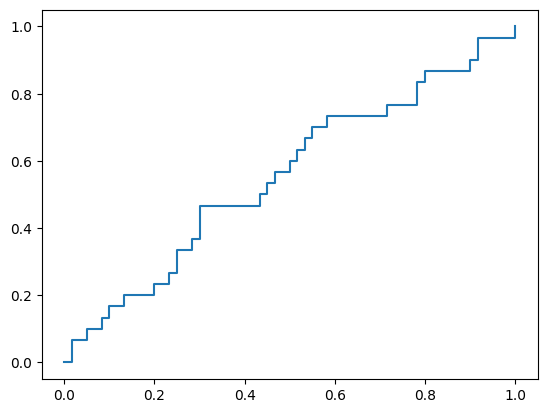

In [ ]:
xplot, yplot, auc = roccurve(params[end], λ)
@show auc

close("all")
plot(xplot,yplot);